<a href="https://colab.research.google.com/github/abdullahshzd01/Attention-is-all-you-need/blob/main/i192012_i190522_i192177_NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd '/content/drive/My Drive/NLP_Project'

/content/drive/My Drive/NLP_Project


In [7]:
import pandas as pd
file_name = 'English.txt'
filee=open(file_name)
English_Content=[]
for line in filee:
  English_Content.append(line.replace('\n',''))

file_name='Urdu.txt'
filee=open(file_name)
Urdu_Content=[]
for line in filee:
  Urdu_Content.append(line.replace('\n',''))

df1 = pd.Series(English_Content)
df2 = pd.Series(Urdu_Content)
data=pd.concat([df1, df2], axis=1)
data.rename(columns = {0:'English',1:'Urdu'}, inplace = True)

In [8]:
!pip install Keras-Preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.4 MB/s eta 0:00:00


In [9]:
import warnings
warnings.filterwarnings('ignore')
import string
import re
from unicodedata import normalize
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential,load_model
from keras.layers import LSTM,Dense,Embedding,RepeatVector,TimeDistributed
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import corpus_bleu
import pandas as pd
from string import punctuation
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))

In [10]:
dataset = data.sample(frac=1, random_state=0)
dataset.iloc[1000:1010]

,English,Urdu
49563,Older students should attend now and there is ...,پرانے طالبعلم اب یہاں حاضری دیں اور نئے طالبعل...
49733,"""I didn't want to investigate in case it was s...","""میں اس معاملے میں تفتیش نہیں کرنا چاہتا تھا ک..."
87086,Perhaps we could simply all try it together on...,مسٹر صدر ، شاید ہم سب مل کر ایک بار پھر کوشش ک...
97372,"""If it's not against Iran, then who is it agai...","""اگر یہ ایران کے خلاف نہیں ہے تو پھر یہ کس کے ..."
11049,"The dollar index, which tracks the greenback a...",ڈالر انڈیکس ، جو اپنے ہم عمر افراد کی ٹوکری کے...
85351,Perhaps I never will.,شاید میں کبھی نہیں کروں گا۔
27506,"Yes, Mr MacCormick, because according to my in...",ہاں ، مسٹر میک میکرک ، کیوں کہ میری معلومات کے...
66891,"You'll see them again.""","آپ انہیں دوبارہ دیکھیں گے۔ """
10561,There is simply less room for blokes who put 2...,بلیک کے لئے صرف کم گنجائش ہے جو ہر ہفتے اپنے ج...
31701,Let's get rid of Zarqawi.,چلو زرقاوی سے تو جان چھوٹی ۔


In [11]:
total_sentences = 1000
test_proportion = 0.1
train_test_threshold = int( (1-test_proportion) * total_sentences)

printmd(f'## {total_sentences} "parallel sentences" will be loaded (original sentence + its translation)')
printmd(f'## {train_test_threshold} "parallel sentences" will be used to train the model')
printmd(f'## {total_sentences-train_test_threshold} "parallel sentences" will be used to test the model')

## 1000 "parallel sentences" will be loaded (original sentence + its translation)

## 900 "parallel sentences" will be used to train the model

## 100 "parallel sentences" will be used to test the model

In [12]:
def clean(string):
    # Clean the string
    string = str(string).replace("\u202f"," ") # Replace no-break space with space
    string = string.lower()
    
    # Delete the punctuation and the numbers
    for p in punctuation + "«»" + "0123456789":
        string = string.replace(p," ")
        
    string = re.sub('\s+',' ', string)
    string = string.strip()
           
    return string


# Clean the sentences
dataset["English"] = dataset["English"].apply(lambda x: clean(x))
dataset["Urdu"] = dataset["Urdu"].apply(lambda x: clean(x))

# Select one part of the dataset
dataset = dataset.values
dataset = dataset[:total_sentences]

# split into train/test
train, test = dataset[:train_test_threshold], dataset[train_test_threshold:]

# Define the name of the source and of the target
# This will be used in the outputs of this notebook
source_str, target_str = "Urdu", "English"

# The index in the numpy array of the source and of the target
idx_src, idx_tar = 1, 0

In [13]:
pd.DataFrame(dataset[1000:1010])

,0,1


In [14]:
import tensorflow as tf
from tensorflow.python.keras import backend as K

# adjust values to your needs
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 0 , 'CPU': 4} )
sess = tf.compat.v1.Session(config=config) 
K.set_session(sess)

In [15]:
def create_tokenizer(lines):
    # fit a tokenizer
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer
 
def max_len(lines):
    # max sentence length
    return max(len(line.split()) for line in lines)

def encode_sequences(tokenizer, length, lines):
    # encode and pad sequences
    X = tokenizer.texts_to_sequences(lines) # integer encode sequences
    X = pad_sequences(X, maxlen=length, padding='post') # pad sequences with 0 values
    return X
 
def encode_output(sequences, vocab_size):
    # one hot encode target sequence
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = np.array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y
 
# Prepare target tokenizer
tar_tokenizer = create_tokenizer(dataset[:, idx_tar])
tar_vocab_size = len(tar_tokenizer.word_index) + 1
tar_length = max_len(dataset[:, idx_tar])
printmd(f'\nTarget ({target_str}) Vocabulary Size: {tar_vocab_size}')
printmd(f'Target ({target_str}) Max Length: {tar_length}')

# Prepare source tokenizer
src_tokenizer = create_tokenizer(dataset[:, idx_src])
src_vocab_size = len(src_tokenizer.word_index) + 1
src_length = max_len(dataset[:, idx_src])
printmd(f'\nSource ({source_str}) Vocabulary Size: {src_vocab_size}')
printmd(f'Source ({source_str}) Max Length: {src_length}\n')
 
# Prepare training data
trainX = encode_sequences(src_tokenizer, src_length, train[:, idx_src])
trainY = encode_sequences(tar_tokenizer, tar_length, train[:, idx_tar])
trainY = encode_output(trainY, tar_vocab_size)

# Prepare test data
testX = encode_sequences(src_tokenizer, src_length, test[:, idx_src])
testY = encode_sequences(tar_tokenizer, tar_length, test[:, idx_tar])
testY = encode_output(testY, tar_vocab_size)


Target (English) Vocabulary Size: 3872

Target (English) Max Length: 28


Source (Urdu) Vocabulary Size: 3809

Source (Urdu) Max Length: 98


In [16]:
def create_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
    # Create the model
    model = Sequential()
    model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
    model.add(LSTM(n_units))
    model.add(RepeatVector(tar_timesteps))
    model.add(LSTM(n_units, return_sequences=True))
    model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
    return model
 
# Create model
model = create_model(src_vocab_size, tar_vocab_size, src_length, tar_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy')

history = model.fit(trainX, 
          trainY, 
          epochs=200, 
          batch_size=64, 
          validation_split=0.1, 
          verbose=1,
          callbacks=[
                        EarlyStopping(
                        monitor='val_loss',
                        patience=2,
                        restore_best_weights=True
                    )
            ])

Epoch 1/200
13/13 [==============================] - 30s 2s/step - loss: 7.1492 - val_loss: 4.4781
Epoch 2/200
13/13 [==============================] - 19s 1s/step - loss: 4.0117 - val_loss: 4.1360
Epoch 3/200
13/13 [==============================] - 21s 2s/step - loss: 3.8606 - val_loss: 4.1356
Epoch 4/200
13/13 [==============================] - 20s 2s/step - loss: 3.7496 - val_loss: 4.0615
Epoch 5/200
13/13 [==============================] - 19s 1s/step - loss: 3.6753 - val_loss: 3.9489
Epoch 6/200
13/13 [==============================] - 21s 2s/step - loss: 3.6125 - val_loss: 3.8859
Epoch 7/200
13/13 [==============================] - 19s 1s/step - loss: 3.5419 - val_loss: 3.9204
Epoch 8/200
13/13 [==============================] - 19s 1s/step - loss: 3.5022 - val_loss: 3.8757
Epoch 9/200
13/13 [==============================] - 23s 2s/step - loss: 3.5169 - val_loss: 3.8337
Epoch 10/200
13/13 [==============================] - 19s 1s/step - loss: 3.5076 - val_loss: 3.8055
Epoch 11/

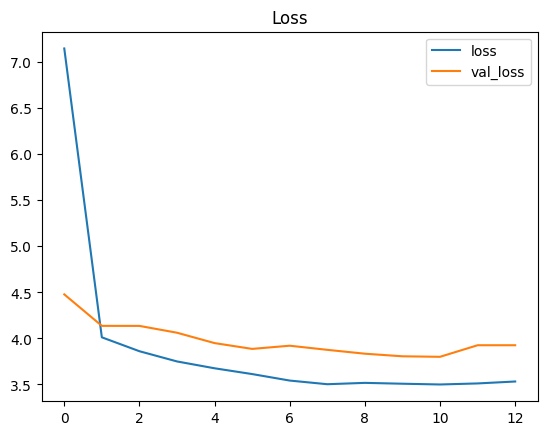

In [17]:
pd.DataFrame(history.history).plot()
plt.title("Loss")
plt.show()

In [18]:
def word_for_id(integer, tokenizer):
    # map an integer to a word
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [19]:
def predict_seq(model, tokenizer, source):
    # generate target from a source sequence
    prediction = model.predict(source, verbose=0)[0]
    integers = [np.argmax(vector) for vector in prediction]
    target = list()
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)

In [20]:
def compare_prediction(model, tokenizer, sources, raw_dataset, limit=20):
    # evaluate a model
    actual, predicted = [], []
    src = f'{source_str.upper()} (SOURCE)'
    tgt = f'{target_str.upper()} (TARGET)'
    pred = f'AUTOMATIC TRANSLATION IN {target_str.upper()}'
    print(f'{src:30} {tgt:25} {pred}\n')
    
    for i, source in enumerate(sources): # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_seq(model, tar_tokenizer, source)
        raw_target, raw_src = raw_dataset[i]
        print(f'{raw_src:30} {raw_target:25} {translation}')
        if i >= limit: # Display some of the result
            break

In [21]:
# test on some training sequences
print('### Result on the Training Set ###')
compare_prediction(model, tar_tokenizer, trainX, train)

### Result on the Training Set ###
URDU (SOURCE)                  ENGLISH (TARGET)          AUTOMATIC TRANSLATION IN ENGLISH

خاموش رہنا ۔                   hold one s peace tongue   
دن کے آخر میں یہ پرانے زمانے کی اخلاقیات کی طرف آتا ہے۔ at the end of the day it comes back to old fashioned ethics the the the the the
گالی دینا ۔ مشکل الفاظ ۔       hard words                the
یوروپیائی پارلیمنٹ نے apply • îœî s کا اطلاق کرنے کا فیصلہ کیا ہے اور ہم کونسل کی بھی یہی امید رکھتے ہیں۔ the european parliament has decided to apply the îîîs and we expect the same of the council the the the the the the the
سادہ ۔                         in simple phrase          
دوا کی گولیوں پر قند چڑھانے کی کیا ضرورت تھی اگر وہ کڑوی نہ ہوتیں ؟ apothecaries would not sugar their pills unless they were bitter the the the the the
ویووا کے مہمات کے منیجر جسٹن کیرسویل نے کہا کیا برطانیہ میں ڈیری فارمنگ کوئی کم ڈوب سکتی ہے؟ justin kerswell campaigns manager for viva said can dairy farming in the uk sink any l

In [22]:
# test on some test sequences
print('\n\n### Result on the Test Set ###')
compare_prediction(model, tar_tokenizer, testX, test)



### Result on the Test Set ###
URDU (SOURCE)                  ENGLISH (TARGET)          AUTOMATIC TRANSLATION IN ENGLISH

جیسا باپ ویسا بیٹا ۔           he is his father s son    
ایم ٹی مسٹر صدر ، میں بھی امیگریشن کے بارے میں بات کروں گا۔ mt mr president i too will be speaking about immigration the the the the the
در حقیقت ، اس کے برعکس معاملہ ہے ایک چیک کے طور پر ، میں بھی یوروپی ہوں۔ in fact the opposite is the case as a czech i am also a european the the the the the the
رابرٹ کی حقیقت میں اس کے گیراج میں ایک پروٹو ٹائپ تھی۔ robert actually had a prototype in his garage ” the the the the the
اس کا بانڈ پچاس لاکھ ڈالر ہے۔  his bond is set at million the the the
ناتارنگ ، مہاراشٹرا کے ایک لوک رقص کے بارے میں بننے والی فلم ، بہت سارے معاملات میں راہ توڑنے والا ثابت ہورہی ہے۔ natarang a film about a folk dance of maharashtra is proving to be a path breaker on many counts the the the the the the the the
جیری براؤن مسلسل اس کی ناک کو سیاسی اسٹیبلشمنٹ میں چھپا رہا تھا ، اس کے والد ، پیٹ 